# Predicting Student Performce

We are given dataset for student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Let's use this data to train a model for predicting student performace.

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [40]:
df = pd.read_csv('data/student-por.csv', delimiter=';')
print(df.info())
print(df.nunique())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [41]:
df.drop(['reason', 'school', 'Mjob', 'Fjob', 'romantic', 'paid', 'Pstatus', 'G1', 'G2'], axis=1, inplace=True)

df['sex'] = np.where(df['sex'] == 'M', 1, 0)

df.loc[df['address'] == 'U', 'address'] = 1
df.loc[df['address'] == 'R', 'address'] = 0

# Or use map/replace 
df[df == 'yes'] = 1
df[df == 'no'] = 0

columns_to_encode = ['famsize', 'guardian']
df = pd.get_dummies(df, prefix=columns_to_encode, columns=columns_to_encode, dtype=int)
df.head()

,sex,age,address,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,Walc,health,absences,G3,famsize_GT3,famsize_LE3,guardian_father,guardian_mother,guardian_other
0,0,18,1,4,4,2,2,0,1,0,0,1,1,0,4,3,4,1,1,3,4,11,1,0,0,1,0
1,0,17,1,1,1,1,2,0,0,1,0,0,1,1,5,3,3,1,1,3,2,11,1,0,1,0,0
2,0,15,1,1,1,1,2,0,1,0,0,1,1,1,4,3,2,2,3,3,6,12,0,1,0,1,0
3,0,15,1,4,2,1,3,0,0,1,1,1,1,1,3,2,2,1,1,5,0,14,1,0,0,1,0
4,0,16,1,3,3,1,2,0,0,1,0,1,1,0,4,3,2,1,2,5,0,13,1,0,1,0,0


In [42]:
X, y = df.drop('G3', axis=1), df['G3']
X.shape, y.shape

((649, 26), (649,))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

In [45]:
param_grid = {
    'model__max_depth': [None, 10, 100, 500],
    'model__min_samples_split': [2, 10, 50],
    'model__n_estimators': [10, 100, 500],
    'model__max_features': [10, 30, 42],
}

grid_search = RandomizedSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=3)
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=3,
                   param_distributions={'model__max_depth': [None, 10, 100,
                                                             500],
                                        'model__max_features': [10, 30, 42],
                                        'model__min_samples_split': [2, 10, 50],
                                        'model__n_estimators': [10, 100, 500]},
                   scoring='neg_mean_squared_error')

In [46]:
grid_search.best_params_

{'model__n_estimators': 500,
 'model__min_samples_split': 10,
 'model__max_features': 10,
 'model__max_depth': 500}

In [47]:
model = grid_search.best_estimator_

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

7.516481205865963

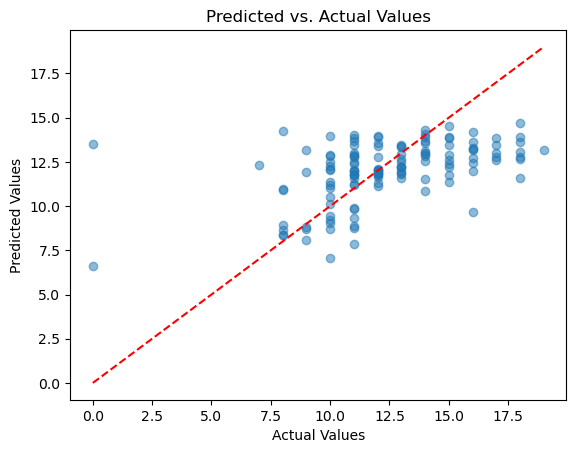

In [48]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Ideal line
plt.show()

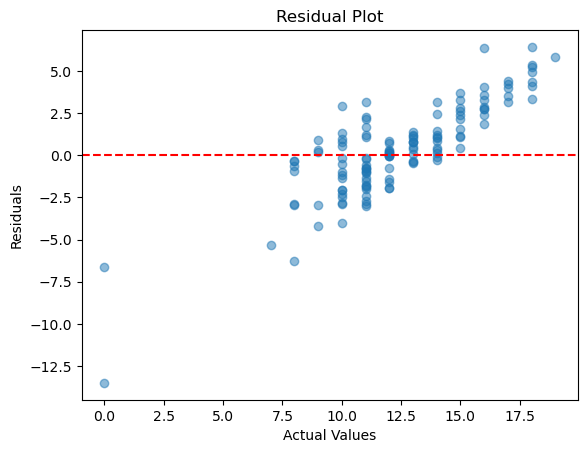

In [49]:
residuals = y_test - y_pred

plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

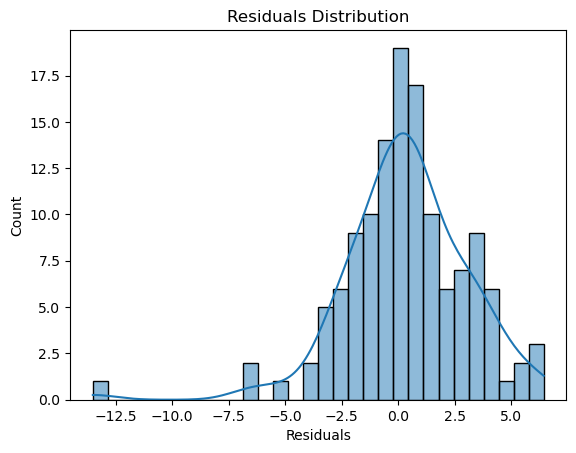

In [50]:
import seaborn as sns

sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()


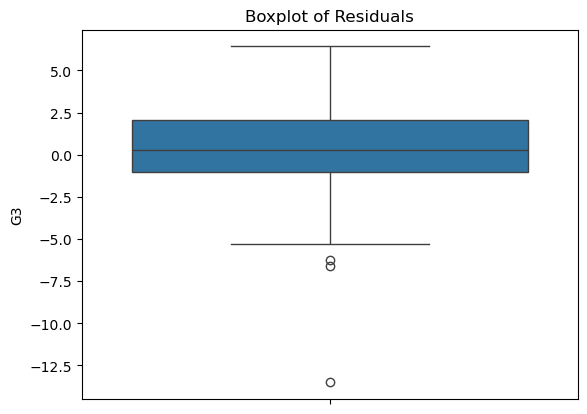

In [51]:
sns.boxplot(y=residuals)
plt.title("Boxplot of Residuals")
plt.show()

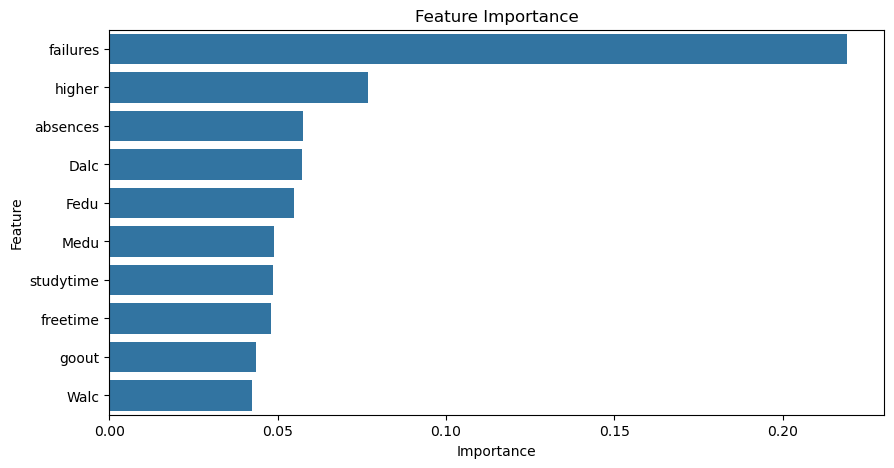

In [52]:
feature_importance = model.named_steps['model'].feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False).nlargest(10, columns=['Importance'])

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance")
plt.show()

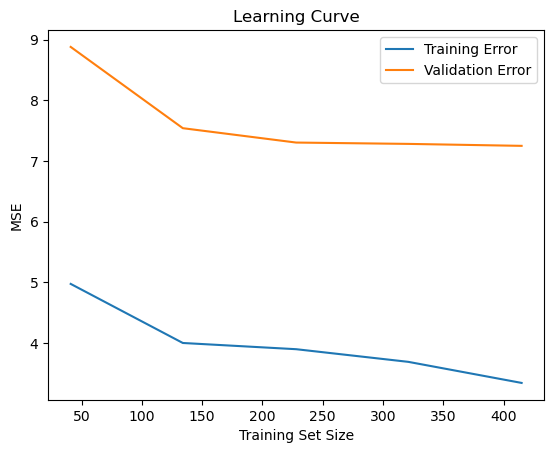

In [53]:
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training Error")
plt.plot(train_sizes, val_scores_mean, label="Validation Error")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve")
plt.show()
